<a href="https://colab.research.google.com/github/nshanbhag2003/Causal-Inference-Replication-Study/blob/main/AMLHW5Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 1: CNN for IMDB review classification

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint # for prettier print when it comes to text

In [ ]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is available.


 ## 1. Text classification via BoW and Logistic classifier

### a) Data exploration and processing

In [ ]:
import os, tarfile, urllib.request
# The following code downloads the data, extract the tar file into DATA_DIR
# if the folder has not yet been downloaded and extracted
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
DATA_DIR = "aclImdb" # Replace with your download folder

if not os.path.exists(DATA_DIR):
    print("Downloading IMDB dataset...")
    urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz")

    print("Extracting...")
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall()
    print("Done!")
else:
    print("IMDB dataset already exists.")

Extracting...


/tmp/ipython-input-2607231566.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Done!


In [ ]:
from pathlib import Path
# The following function helps you load the training and test data where each
# review is a single string vector with label 1 if positive, 0 otherwise
# We should be loading 25000 train and 25000 test reviews.

def load_imdb_split(split_dir):
    texts, labels = [], []
    for label_type in ["pos", "neg"]:
        dir_path = Path(split_dir)/label_type
        for file_path in dir_path.iterdir():
            with open(file_path, encoding="utf-8") as f:
                texts.append(f.read())
            labels.append(1 if label_type == "pos" else 0)
    return texts, labels

train_texts, train_labels = load_imdb_split(DATA_DIR + "/train")
test_texts, test_labels   = load_imdb_split(DATA_DIR + "/test")

print(f"Loaded {len(train_texts)} train and {len(test_texts)} test reviews.")

Loaded 25000 train and 25000 test reviews.


In [ ]:
# Display the first train review's first 500 characters
pprint(train_texts[0][:500])

('This was a very enjoyable film. A humorous, but poignant look at family, and '
 'the obligations that come with it. The story of a man who comes home from '
 'his life in the city to his fathers bath house in a small Chinese village. '
 'There he learns to appreciate, even cherish the very things he left home to '
 'get away from. The film is as visually beautiful as it is emotionally '
 'beautiful.')


### b. Bag of words

In [ ]:
import re, html, unicodedata
from sklearn.feature_extraction.text import CountVectorizer
# Here we give an example of steps one can take when cleaning text data before construction BoW
# basic_clean will be a custom function we can establish for specific cleaning steps. Here IMDB
# reviews are scrapped from the web page, the url and tag replacement steps can be crucial here
# depending on the downstream method

URL_RE   = re.compile(r'https?://\S+|www\.\S+')
TAG_RE   = re.compile(r'<[^>]+>')
NUM_RE   = re.compile(r'\b\d+([.,]\d+)*\b')
WS_RE    = re.compile(r'\s+')
APOSTROPHE_RE = re.compile(r"[’`´]")
CONTRACTIONS = {
    "can't": "can not", "won't": "will not", "n't": " not",
    "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"
}

def basic_clean(text):
    text = html.unescape(text) # HTML entities & tags removal
    text = TAG_RE.sub(' ', text)
    def strip_accents(s):
      return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    text = strip_accents(text) #  normalize unicode & accents
    text = APOSTROPHE_RE.sub("'", text) # normalize apostrophes to plain '
    text = URL_RE.sub(' <url> ', text) # replace urls/emails/numbers with placeholders
    text = re.sub(r'\S+@\S+\.\S+', ' <email> ', text)
    text = NUM_RE.sub(' <num> ', text)
    for k, v in CONTRACTIONS.items(): #  expand contractions (eg negations)
        text = text.replace(k, v)
    text = re.sub(r"[^a-z0-9<> ]+", " ", text) #  remove punctuation (keep spaces and angle-bracket tokens)
    text = WS_RE.sub(' ', text).strip() # collapse whitespace
    return text

vectorizer = CountVectorizer(
    preprocessor = basic_clean, # pass the basic_clean function for custom processing
    tokenizer=None, # let sklearn do default tokenization
    lowercase=True, # convert text to lowercase
    stop_words='english', # stop_words='english' to drop common fillers
    min_df = 5, # ignore very rare terms
    max_df = 0.8, # ignore very common terms
    max_features=None, # if 600 f.e. would retain top 600 features
)

bow_train = vectorizer.fit_transform(train_texts) # cleaned vectorized train bow
vocabulary = vectorizer.get_feature_names_out() # get the vocabulary constructed from bow

In [ ]:
vocabulary[0:10]

array(['00s', '100th', '10s', '10th', '11th', '12', '12th', '13', '13th',
       '14'], dtype=object)

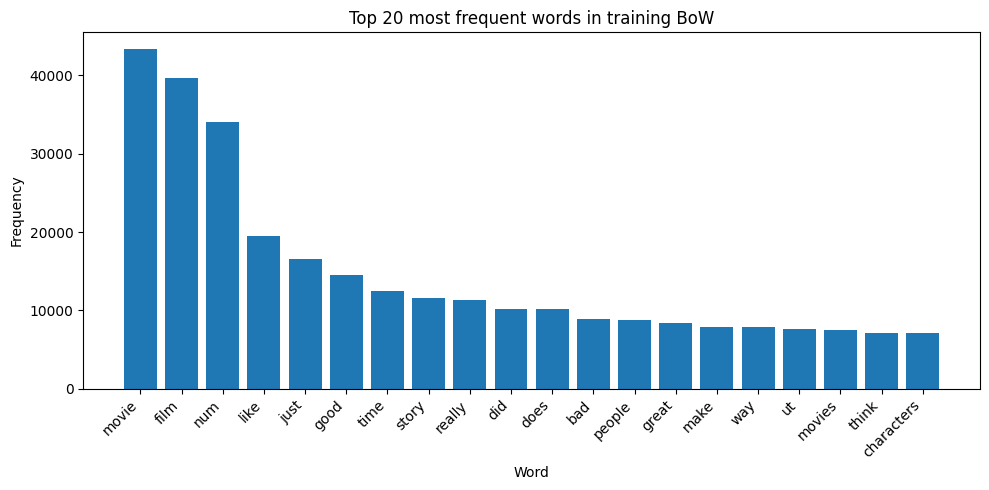

In [ ]:
word_freq = np.asarray(bow_train.sum(axis=0)).ravel()
sorted_idx = np.argsort(word_freq)[::-1]

N = 20
top_words = [vocabulary[i] for i in sorted_idx[:N]]
top_freqs = word_freq[sorted_idx[:N]]

plt.figure(figsize=(10,5))
plt.bar(top_words, top_freqs)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 most frequent words in training BoW")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader

ROOT = Path(DATA_DIR)
TRAIN_FEAT = ROOT / "train" / "labeledBow.feat"
TEST_FEAT  = ROOT / "test"  / "labeledBow.feat"
VOCAB_FILE = ROOT / "imdb.vocab"
corpus = open(TRAIN_FEAT, encoding="utf-8").read().strip().splitlines()
with open(VOCAB_FILE, encoding="utf-8") as f:
    vocab = [line.strip() for line in f]
print(len(vocab))

89527


In [ ]:
print(corpus[0][:100])

9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57


In [ ]:
vocab[0:10]

['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']

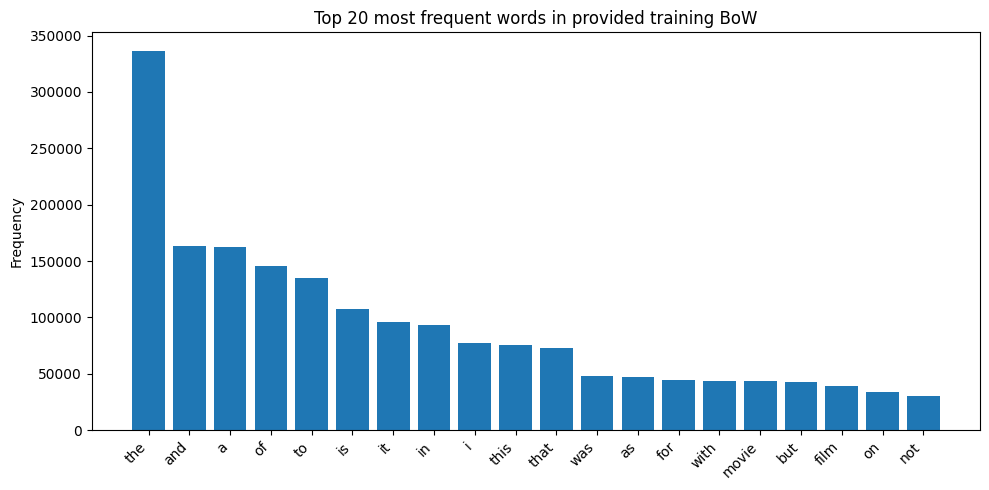

In [ ]:
vocab_size = len(vocab)
freq = np.zeros(vocab_size, dtype=np.float64)
for line in corpus:
    parts = line.split()
    for tok in parts[1:]:
        k, c = tok.split(":")
        idx = int(k)
        cnt = float(c)
        if 0 <= idx < vocab_size:
            freq[idx] += cnt

top_idx = np.argsort(freq)[-N:][::-1]  # largest to smallest
top_words = [vocab[i] for i in top_idx]
top_freqs = freq[top_idx]

plt.figure(figsize=(10, 5))
ypos = np.arange(len(top_words))[::-1]  # most frequent at top
plt.bar(ypos, top_freqs[::-1])
plt.xticks(ypos, top_words[::-1], rotation=45, ha='right')
plt.ylabel("Frequency")
plt.title(f"Top {N} most frequent words in provided training BoW")
plt.tight_layout()
plt.show()

### **Question 1a**
* How is a negative review defined in this dataset? Positive review? Can you explain how each `.txt` file is named?
* Can you explain the logic behind the encoding of the printed 100 characters of the first entry of `corpus`? In particular, what does it mean to see **x:y**? Note that the first element of `corpus[0]` is the rating corresponding to the review 0.
* Can you comment the difference in the top 20 most frequent words obtained via the sklearn `CountVectorizer` method and the provided BoW? Can you modify parameters in `CountVectorizer` to get more similar BoW distribution?
* What are the drawbacks of using BoW?

**Your answer**:

* In this dataset, a negative review is any review stored in the `neg` folder and labeled `0`, while a positive review is in the `pos` folder and labeled `1`. Each `.txt` file is named `<reviewID>_<rating>.txt`, where `reviewID` is unique and `rating` is the original IMDb score (typically 1–4 for negative, 7–10 for positive).
* Each line in `corpus` corresponds to one review in BoW format. The first number is the IMDb rating for that review. Each x:y pair represents a word from the vocabulary: `x` is the index of the word in `imdb.vocab` and `y` is the count of how many times that word appears in the review. For example, 4:6 means the word at index 4 occurs 6 times in the review.
* The top 20 most frequent words differ because `CountVectorizer` removes stop words, applies lowercase conversion, and filters very rare or very common words, while the provided BoW (`labeledBow.feat`) preserves all words in the vocabulary. This is why the top words for the provided BoW are very common, such as 'the', 'and', 'a'. To make `CountVectorizer` produce a distribution closer to the provided BoW, you can disable stop-word removal (`stop_words=None`), include all words by setting `min_df=1` and `max_df=1.0`, and maybe even keep the original case (`lowercase=False`).
* BoW ignores word order and context, so it cannot capture the meaning of phrases or syntax. It often results in very high-dimensional and sparse vectors, which can be memory-intensive and slow for larger vocabularies. BoW also treats all words independently, so it cannot distinguish between words with multiple meanings or capture semantic similarity.



### **Instructions 1b**

In [ ]:
def transform_rating(rating):
  ###### YOUR CODE HERE #######
  return 1 if rating >= 7 else 0

class BoWDataset(Dataset):
  def __init__(self, feat_path: Path, vocab_path: Path):
    # construct corpus as vector of all documents
    self.corpus = open(feat_path, encoding="utf-8").read().strip().splitlines()
    with open(vocab_path, encoding="utf-8") as f:
        vocab = [line.strip() for line in f]
    self.vocab_size =len(vocab)

  def __len__(self):
    return len(self.corpus)

  def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor, int]:
    document = self.corpus[idx].split()[1:] # document at index idx
    rating = int(self.corpus[idx].split()[0])
    label = transform_rating(rating) # transform 1-10 int into 0/1 based on README

    idxs, vals = [], []
    for tok in document:
      ###### YOUR CODE HERE #######
      k, c = tok.split(":")
      idxs.append(int(k))  # get frequencies
      vals.append(float(c)) # get binary labels
    return torch.tensor(idxs, dtype=torch.long), torch.tensor(vals, dtype=torch.float32), torch.tensor(label, dtype=torch.long) # returns (indices, values, label)


In [ ]:
B = 512
##### YOUR CODE HERE ######
# define train and test datasets
train_dataset = BoWDataset(TRAIN_FEAT, VOCAB_FILE)
test_dataset  = BoWDataset(TEST_FEAT, VOCAB_FILE)

# define train_loader and test_loader
def bow_collate_fn(batch):
    vocab_size = train_dataset.vocab_size  # total number of words
    batch_size = len(batch)

    X = torch.zeros((batch_size, vocab_size), dtype=torch.float32)
    y = torch.zeros(batch_size, dtype=torch.long)

    for i, (idxs, vals, label) in enumerate(batch):
        X[i, idxs] = vals
        y[i] = label

    return X, y

train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=bow_collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=B, shuffle=False, collate_fn=bow_collate_fn)

### c) Logistic classifier for text classification

### **Instructions 1c**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

##### YOUR CODE HERE #####

# Define your logistic classifier and prepare training
model = nn.Sequential(
    nn.Linear(vocab_size, 1),
    nn.Sigmoid()
)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [ ]:
import tqdm
def train(model, train_loader, criterion, optimizer, device=None):
  if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.to(device)
  model.train()
  total_loss, total_correct, total_examples = 0.0, 0, 0

  for X, y in train_loader:
      X, y = X.to(device), y.to(device)
      ##### YOUR CODE HERE #####
      optimizer.zero_grad()
      y_pred = model(X)
      loss = criterion(y_pred, y.float().unsqueeze(1))
      loss.backward()
      optimizer.step()

      total_loss += loss.item() * X.size(0)
      preds = (y_pred > 0.5).long()
      total_correct += (preds.squeeze() == y).sum().item()
      total_examples += X.size(0)

  avg_loss = total_loss / total_examples
  avg_acc = total_correct / total_examples
  return avg_loss, avg_acc

def eval_step(model, val_loader, criterion, device=None):
  if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.to(device)
  total_loss, total_correct, total_examples = 0.0, 0, 0
  model.eval()

  all_preds, all_labels = [], []

  with torch.no_grad():
    for X, y in val_loader:
        ##### YOUR CODE HERE #####
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y.float().unsqueeze(1))

        total_loss += loss.item() * X.size(0)
        preds = (y_pred > 0.5).long().squeeze()
        total_correct += (preds == y).sum().item()
        total_examples += X.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

  from sklearn.metrics import confusion_matrix, classification_report
  cm = confusion_matrix(all_labels, all_preds)
  report = classification_report(all_labels, all_preds, output_dict=True)

  avg_loss = total_loss / total_examples
  avg_acc = total_correct / total_examples
  return avg_loss, avg_acc, cm, report

In [ ]:
hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
epochs = 10

for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, cm, report = eval_step(model, test_loader, criterion)
    hist["val_loss"].append(val_loss)
    hist["val_acc"].append(val_acc)
    hist["train_loss"].append(train_loss)
    hist["train_acc"].append(train_acc)
    lr_scheduler.step()
    if epoch%10:
      print(f"Epoch {epoch + 1}: | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

print("Final accuracy:", hist["train_acc"][-1])

 20%|██        | 2/10 [00:37<02:31, 18.88s/it]

Epoch 2: | Train Loss: 0.3613 | Train Acc: 90.40% | Val Loss: 0.3997 | Val Acc: 86.79%


 30%|███       | 3/10 [00:56<02:11, 18.85s/it]

Epoch 3: | Train Loss: 0.3180 | Train Acc: 91.80% | Val Loss: 0.3760 | Val Acc: 87.21%


 40%|████      | 4/10 [01:15<01:54, 19.00s/it]

Epoch 4: | Train Loss: 0.2872 | Train Acc: 92.73% | Val Loss: 0.3623 | Val Acc: 87.42%


 50%|█████     | 5/10 [01:36<01:37, 19.55s/it]

Epoch 5: | Train Loss: 0.2646 | Train Acc: 93.46% | Val Loss: 0.3487 | Val Acc: 87.76%


 60%|██████    | 6/10 [01:55<01:17, 19.39s/it]

Epoch 6: | Train Loss: 0.2458 | Train Acc: 94.04% | Val Loss: 0.3388 | Val Acc: 87.92%


 70%|███████   | 7/10 [02:14<00:58, 19.44s/it]

Epoch 7: | Train Loss: 0.2306 | Train Acc: 94.50% | Val Loss: 0.3323 | Val Acc: 88.12%


 80%|████████  | 8/10 [02:33<00:38, 19.33s/it]

Epoch 8: | Train Loss: 0.2180 | Train Acc: 94.94% | Val Loss: 0.3264 | Val Acc: 88.25%


 90%|█████████ | 9/10 [02:53<00:19, 19.44s/it]

Epoch 9: | Train Loss: 0.2067 | Train Acc: 95.28% | Val Loss: 0.3224 | Val Acc: 88.32%


100%|██████████| 10/10 [03:13<00:00, 19.32s/it]

Epoch 10: | Train Loss: 0.1970 | Train Acc: 95.55% | Val Loss: 0.3186 | Val Acc: 88.40%
Final accuracy: 0.95548


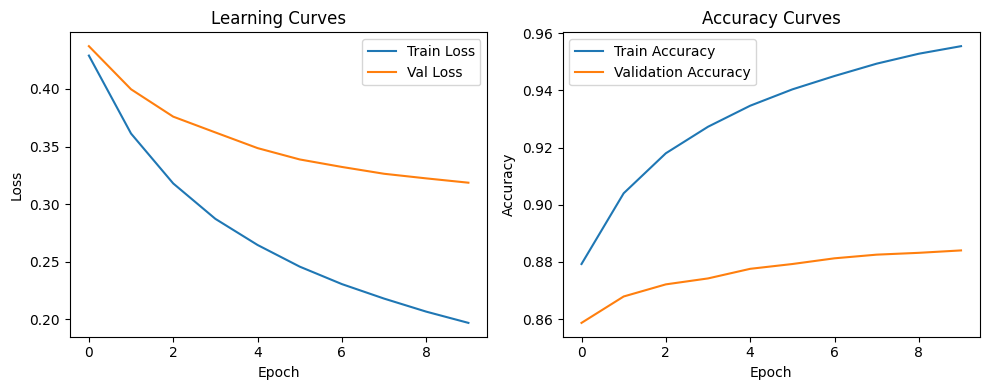

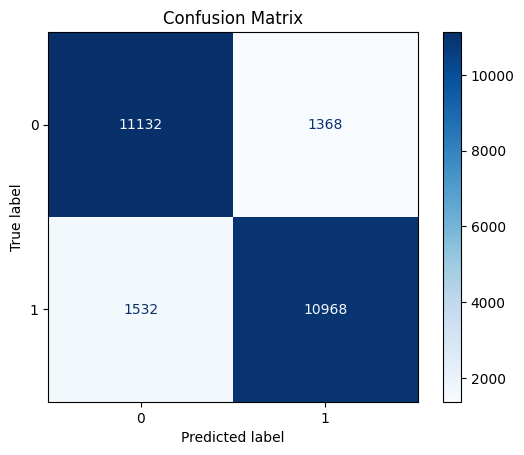

In [ ]:
##### YOUR CODE HERE ######
# Plot learning curves and other diagnostics

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves")

plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train Accuracy")
plt.plot(hist["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.tight_layout()
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## 2. Word Embeddings for Text Classification

### Introduction to word embeddings

In [ ]:
# Do not need to run this cell, this is an illustration of the type of annotations
# that used to be curated in wordnet
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
statistics = wn.synset("statistics.n.01")
poses = {'n':'noun', 'v':'verb', 's':'adj (s)', 'a':'adj', 'r':'adv'}
hyper = lambda s: s.hypernyms()
list(statistics.closure(hyper))

[nltk_data] Downloading package wordnet to /root/nltk_data...


[Synset('applied_mathematics.n.01'),
 Synset('mathematics.n.01'),
 Synset('science.n.01'),
 Synset('discipline.n.01'),
 Synset('knowledge_domain.n.01'),
 Synset('content.n.05'),
 Synset('cognition.n.01'),
 Synset('psychological_feature.n.01'),
 Synset('abstraction.n.06'),
 Synset('entity.n.01')]

In [ ]:
excerpt = train_texts[0:5]
pprint(excerpt[0][:100])

('This was a very enjoyable film. A humorous, but poignant look at family, and '
 'the obligations that co')


In [ ]:
def tokenize(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9']+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

clean = [basic_clean(excerpt[i]) for i in range(5)]
print("Before cleaning:", excerpt[0][:15])
print("After cleaning:", clean[0][:16])
tokens = [tokenize(clean[i]) for i in range(5)]
print("Tokenized and cleaned:", tokens[0][:3])
print("Number of tokens in first doc:", len(tokens[0]))

Before cleaning: This was a very
After cleaning: his was a very e
Tokenized and cleaned: ['his', 'was', 'a']
Number of tokens in first doc: 71


In [ ]:
from collections import Counter
import numpy as np

all_tokens = [t for doc in tokens for t in doc]
vocab = sorted(set(all_tokens))
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

word_to_idx = {w: i for i, w in enumerate(vocab)}

def one_hot_encode_word(word, vocab_size):
    vec = np.zeros(vocab_size, dtype=np.float32)
    vec[word_to_idx[word]] = 1.0
    return vec

seq_matrix = np.stack([one_hot_encode_word(w, vocab_size) for w in tokens[0]])
print("One hot encoded document 0's size:", seq_matrix.shape)

Vocabulary size: 534
One hot encoded document 0's size: (71, 534)


### **Instructions 2a**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import numpy as np

def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    words = sorted(set(w for doc in corpus for w in doc))
    return words, len(words) # sorted distinct tokens, count

def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    word2ind = {w: i for i, w in enumerate(words)}
    M = np.zeros((n_words, n_words), dtype=np.float64)

    for doc in corpus:
        idx_seq = [word2ind[w] for w in doc if w in word2ind]
        L = len(idx_seq)
        for i in range(L):
            wi = idx_seq[i]
            right_end = min(L, i + window_size + 1)
            for j in range(i + 1, right_end):
                wj = idx_seq[j]
                M[wi, wj] += 1.0
                M[wj, wi] += 1.0

    return M, word2ind

def reduce_to_k_dim(M, k=2, n_iters=10, random_state=42):
    """Reduce a co-occurrence count matrix M (V x V) to (V x k) using TruncatedSVD.

    Returns U * S (i.e., fit_transform output), which is a dense (V x k) matrix.
    """
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    ###### YOUR CODE HERE ######
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=random_state) # SVD
    M_reduced = svd.fit_transform(M) # Embedding shape: (V, k)
    explained = svd.explained_variance_ratio_.sum() # Variance explained
    print(f"Explained variance (k={k}): {explained:.4f}")
    print("Done.")
    return M_reduced

def plot_embeddings(M_reduced, word2ind, words):
    """Scatter-plot 2D embeddings for a subset of words with labels."""
    assert M_reduced.shape[1] == 2, "M_reduced must be 2D for plotting."

    xs, ys, kept = [], [], []
    for w in words:
        if w in word2ind:
            i = word2ind[w]
            xs.append(M_reduced[i, 0])
            ys.append(M_reduced[i, 1])
            kept.append(w)
        else:
            pass # quietly skip out of vocabulary words

    plt.figure(figsize=(5, 3))
    plt.scatter(xs, ys, s=40)
    for x, y, w in zip(xs, ys, kept):
        plt.text(x + 0.005, y + 0.005, w, fontsize=10)

    plt.title("2D Co-occurrence Embeddings (TruncatedSVD)")
    plt.xlabel("SVD dim 1")
    plt.ylabel("SVD dim 2")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

Running Truncated SVD over 534 words...
Explained variance (k=2): 0.3962
Done.


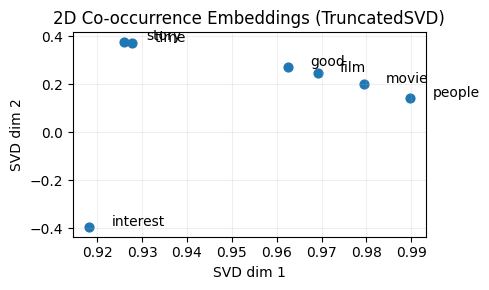

In [ ]:
corpus = tokens # deleted the brackets because it's causing an error
##### YOUR CODE HERE #####
M, word2ind = compute_co_occurrence_matrix(corpus, window_size=4) # build co-occurrence matrix
M_reduced = reduce_to_k_dim(M, k=2) # reduce to 2 dimensions

M_lengths = np.linalg.norm(M_reduced, axis=1, keepdims=True)
M_normalized = M_reduced / np.maximum(M_lengths, 1e-8)

sample_words = ['movie','film','lady','interest','good','time','story', 'sister','people','characters','think']
plot_embeddings(M_normalized, word2ind, sample_words)

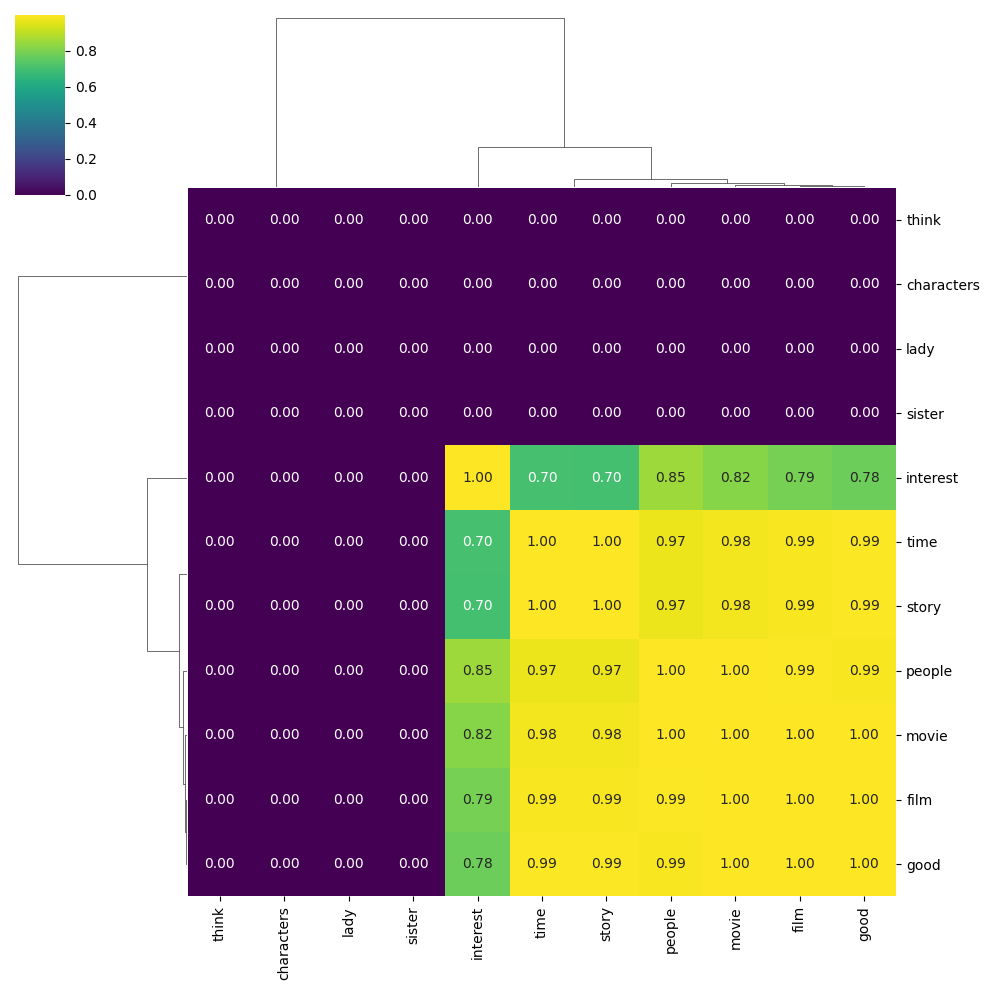

In [ ]:
# Suggest similarity measure
def similarity(w1, w2, M, word2ind, eps=1e-9):
  ##### YOUR CODE HERE #####
  if w1 not in word2ind or w2 not in word2ind:
      return np.nan
  v1 = M[word2ind[w1]]
  v2 = M[word2ind[w2]]
  sim = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + eps)
  return sim

def matrix_similarity(list_words, M, word2ind):
  ##### YOUR CODE HERE #####
  n = len(list_words)
  S = np.zeros((n, n))
  for i in range(n):
      for j in range(n):
          S[i, j] = similarity(list_words[i], list_words[j], M, word2ind)
  return S

# Plot the similarity matrix obtained
##### YOUR CODE HERE #####
import seaborn as sns
import pandas as pd

S = matrix_similarity(sample_words, M_normalized, word2ind)
S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
sns.clustermap(
    pd.DataFrame(S, index=sample_words, columns=sample_words),
    cmap="viridis",
    annot=True,
    fmt=".2f"
)

### **Question 2b**

Running Truncated SVD over 534 words...
Explained variance (k=2): 0.9385
Done.


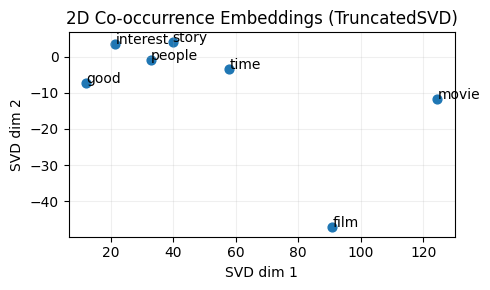

In [ ]:
M, word2ind = compute_co_occurrence_matrix(corpus, window_size=100)
M_reduced = reduce_to_k_dim(M, k=2)
plot_embeddings(M_reduced, word2ind, sample_words)

### **Your answer:**
With a window size of 100, the embeddings become much less informative — most words co-occur with almost all others in each document, so the co-occurrence matrix loses structure. The resulting embedding collapses into a low-variance space where distinctions between words blur. This shows how overly large context windows produce poor-quality embeddings, even though the explained variance increases dramatically from around 0.4 to above 0.9.

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.1 MB/s eta 0:00:00


In [ ]:
def load_embedding_model():
    """ Load word2vec Vectors
        Return:
            wv_from_bin: All embeddings
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded vocab size 3000000


In [ ]:
print(f'Vector dimensionality: {wv_from_bin.vector_size}')

Vector dimensionality: 300


<Figure size 500x500 with 0 Axes>

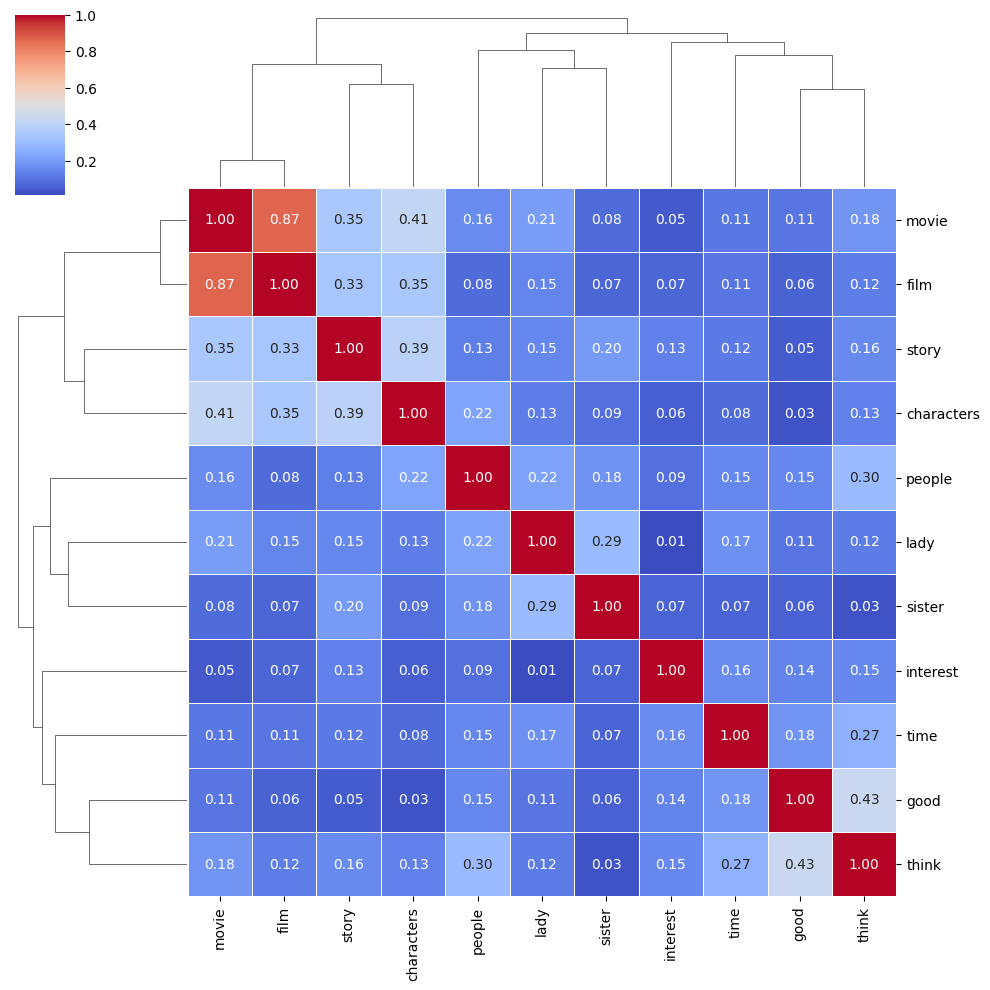

In [ ]:
def w2v_similarity(wv, sample_words):
    kept = []
    for w in sample_words:
      if w in wv:
        kept.append(w)

    normed = getattr(wv, "get_normed_vectors", None)
    if normed is not None:
      idx = [wv.key_to_index[w] if w in wv else None for w in kept]
      vecs = normed()[idx, :]
      similarity = np.clip(vecs @ vecs.T, -1.0, 1.0)
    else:
      print("No normalized vectors")

    return similarity

plt.figure(figsize=(5,5))
sns.clustermap(
    w2v_similarity(wv_from_bin, sample_words),
    xticklabels=sample_words,
    yticklabels=sample_words,
    cmap="coolwarm",        # or "viridis", "magma"
    linewidths=0.5,
    annot=True,
    fmt=".2f"
)

## 3. CNN for text classification

### a. Prepare the Data

## **Instructions & Question 3a**

In [ ]:
# We iterate all the corpus through our cleaning functions and tokenize it
# You can use some of the previously defined functions
#### YOUR CODE HERE ####
train_data = [tokenize(basic_clean(doc)) for doc in train_texts]
test_data = [tokenize(basic_clean(doc)) for doc in test_texts]

In [ ]:
from collections import Counter

def build_vocab(token_docs, max_words=30000, skip_top=0, specials=("<pad>","<oov>")):
    PAD, OOV = specials
    freq = Counter([w for doc in token_docs for w in doc])
    most_common = [w for w,_ in freq.most_common(max_words + skip_top)][skip_top:]
    vocab = [PAD, OOV] + most_common
    word2idx = {w:i for i,w in enumerate(vocab)}
    return vocab, word2idx

vocab, word2idx = build_vocab(train_data)

def build_w2v_embedding_matrix(word2idx, wv, pad_idx=0, oov_idx=1, rand_scale=0.6):
    V = len(word2idx)
    D = wv.vector_size
    emb = np.random.normal(scale=rand_scale, size=(V, D)).astype("float32")
    emb[pad_idx] = 0.0

    found, known_rows = 0, []
    for w, i in word2idx.items():
        if w in wv:
            emb[i] = wv[w]
            found += 1
            if i not in (pad_idx, oov_idx):
                known_rows.append(i)

    if known_rows:
        emb[oov_idx] = emb[known_rows].mean(axis=0)

    print(f"Matched {found}/{V} ({found/V:.1%}) words to pretrained vectors.")
    return torch.tensor(emb)

### Your answer:

`vocab = [PAD, OOV] + most_common` creates the final vocabulary for the model:

- **PAD**: A special token used to pad sequences to a fixed length.
- **OOV**: aka "out-of-vocabulary"; used for words not seen in the training vocabulary.
- **most_common**: The most frequent words from the training corpus.

In [ ]:
emb_matrix = build_w2v_embedding_matrix(word2idx, wv_from_bin)

Matched 22525/30002 (75.1%) words to pretrained vectors.


Documents in class 0: 12500
Documents in class 1: 12500


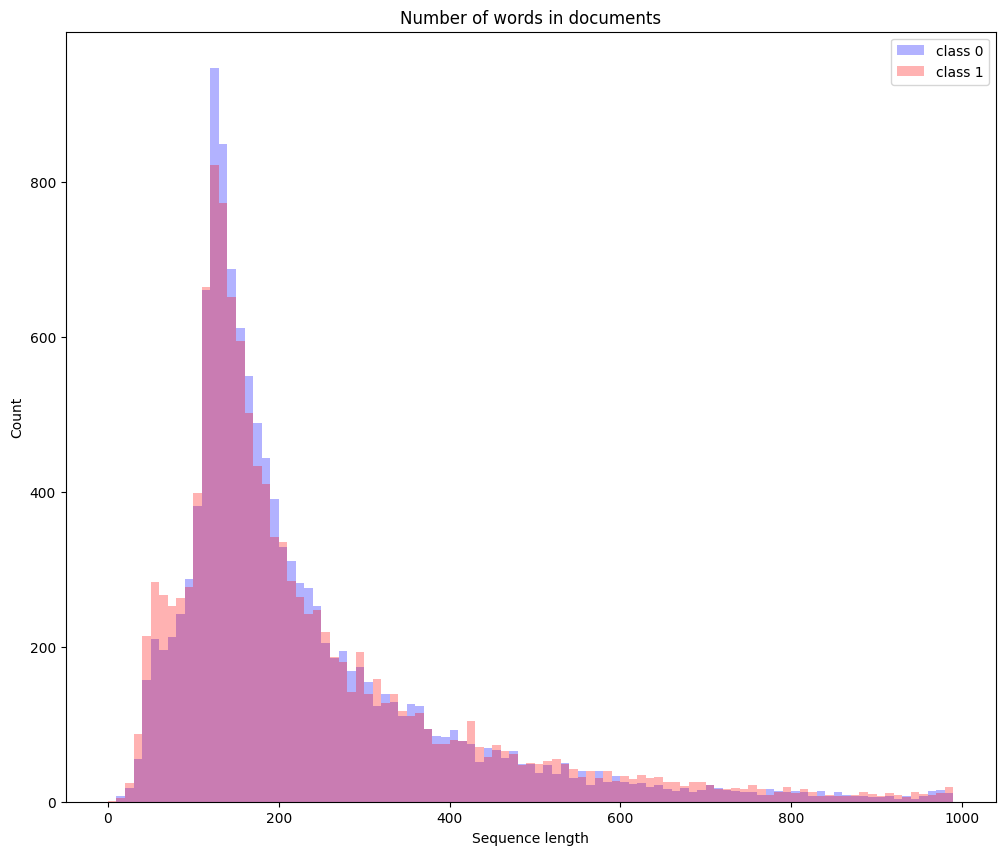

In [ ]:
lens0 = [len(s) for i,s in enumerate(train_data) if train_labels[i] == 0]
lens1 = [len(s) for i,s in enumerate(train_data) if train_labels[i] == 1]

print("Documents in class 0:", len(lens0))
print("Documents in class 1:", len(lens1))

plt.figure(figsize=(12,10))
plt.hist(lens0, bins=range(0, 1000, 10), color="blue", alpha=0.3, label="class 0")
plt.hist(lens1, bins=range(0, 1000, 10), color="red", alpha=0.3, label="class 1")
plt.legend()
plt.title("Number of words in documents")
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.show()

In [ ]:
all_lens = np.array([len(s) for s in train_data])
for p in (90, 95, 98, 99):
    print(f"P{p}: {np.percentile(all_lens, p):.0f}")

# e.g., pick 95th percentile as MAX_LEN:
MAX_LEN = int(np.percentile(all_lens, 95))
print("Chosen MAX_LEN:", MAX_LEN)

# Estimate truncation rate:
trunc_rate = (all_lens > MAX_LEN).mean()
print(f"Truncation rate at MAX_LEN={MAX_LEN}: {trunc_rate*100:.2f}%")

P90: 456
P95: 599
P98: 788
P99: 910
Chosen MAX_LEN: 599
Truncation rate at MAX_LEN=599: 4.99%


In [ ]:
from torch.utils.data import Dataset, DataLoader


def encode(doc, word2idx, oov_idx=1):
    return [word2idx.get(w, oov_idx) for w in doc]

def pad_to_max_len(ids, max_len=600, pad_idx=0):
    ids = ids[:max_len]
    if len(ids) < max_len:
        ids += [pad_idx] * (max_len - len(ids))
    return ids


class TextDataset(Dataset):
  def __init__(self, data, labels, word2idx):
    assert len(data) == len(labels)
    self.X = []
    self.y = []
    for toks, y in zip(data, labels):
        ids = encode(toks, word2idx)
        ids = pad_to_max_len(ids)
        self.X.append(torch.tensor(ids, dtype=torch.long))
        self.y.append(torch.tensor([y], dtype=torch.float32))

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

train_dataloader = DataLoader(TextDataset(train_data, train_labels, word2idx),batch_size=64, shuffle=True)
test_dataloader = DataLoader(TextDataset(test_data, test_labels, word2idx), batch_size=64)

### b. Build the CNN with embedding layer

## **Instructions 3b**

### **Your answer here:**

In this model, the pretrained `word2vec` embeddings are unfrozen, meaning they are trainable. This allows the CNN to fine-tune the embeddings for the IMDB sentiment classification task. Fine-tuning can improve performance by adjusting word vectors to better capture sentiment-relevant features in the dataset. If the embeddings were frozen, they would remain fixed, which can reduce training time and lower the risk of overfitting. Therefore, unfreezing is preferred for larger datasets or when nuances in a task are important, while freezing can be useful for smaller datasets or faster, more stable training.


In [ ]:
# Create the embedding layers, explain whether you choose to freeze the weights are not
##### YOUR CODE HERE #####
embedding = nn.Embedding.from_pretrained(build_w2v_embedding_matrix(word2idx, wv_from_bin),
                                         freeze=False, padding_idx=0)

Matched 22525/30002 (75.1%) words to pretrained vectors.


In [ ]:
# Create the CNN using nn.Sequential
##### YOUR CODE HERE #####

class MultiFilterCNN(nn.Module):
    def __init__(self, embed_dim, num_filters=64, filter_sizes=[3,4,5]):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embed_dim, num_filters, kernel_size=fs),
                nn.ReLU(),
                nn.AdaptiveMaxPool1d(1)
            )
            for fs in filter_sizes
        ])

    def forward(self, x):
        # x: [B, E, L]
        outputs = [conv(x).squeeze(-1) for conv in self.convs]  # each [B, num_filters]
        return torch.cat(outputs, dim=1)  # [B, num_filters * len(filter_sizes)]

# Helper module to do transpose in nn.Sequential
class Transpose(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

# Create the CNN using nn.Sequential
model = nn.Sequential(
    embedding,
    nn.Dropout(0.3),         # hopefully reduce overfitting but looks like not :/
    Transpose(),

    MultiFilterCNN(
        embed_dim=embedding.embedding_dim,
        num_filters=64,
        filter_sizes=[3,4,5]
    ),                      # [B, 64*3 = 192]

    nn.Dropout(0.3),
    nn.Linear(192, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()            # using BCELoss
)


In [ ]:
# Verify that the embedding has selected choice of weight freeze/unfreezing
for name, param in model.named_parameters():
    print(name, param.requires_grad)

0.weight True
3.convs.0.0.weight True
3.convs.0.0.bias True
3.convs.1.0.weight True
3.convs.1.0.bias True
3.convs.2.0.weight True
3.convs.2.0.bias True
5.weight True
5.bias True
8.weight True
8.bias True


### c. Train and evaluate model

### **Instructions 3c**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

##### YOUR CODE HERE ######

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop as usual
def train_epoch(model, dataloader, criterion, optimizer, device=device):
    model.train()
    total_loss, total_correct, total_examples = 0, 0, 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device).float().view(-1, 1)   # ensure shape [B,1] and float

        optimizer.zero_grad()
        y_pred = model(X)                      # output already has sigmoid

        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

        preds = (y_pred > 0.5).long()          # [B,1]
        labels = y.long()                      # [B,1]
        total_correct += (preds == labels).sum().item()
        total_examples += X.size(0)

    return total_loss / total_examples, total_correct / total_examples


# Evaluation as usual
def eval_model(model, dataloader, criterion, device=device):
    model.eval()
    total_loss, total_correct, total_examples = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device).float().view(-1, 1)

            y_pred = model(X)

            loss = criterion(y_pred, y)
            total_loss += loss.item() * X.size(0)

            preds = (y_pred > 0.5).long()
            labels = y.long()

            total_correct += (preds == labels).sum().item()
            total_examples += X.size(0)

            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_labels.extend(labels.cpu().numpy().reshape(-1))

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    return avg_loss, avg_acc, cm, report

 10%|█         | 1/10 [00:17<02:39, 17.72s/it]

Epoch 1/10: Train Loss=0.5854, Train Acc=66.83%, Val Loss=0.3625, Val Acc=84.04%


 20%|██        | 2/10 [00:33<02:14, 16.87s/it]

Epoch 2/10: Train Loss=0.3231, Train Acc=86.39%, Val Loss=0.2994, Val Acc=87.41%


 30%|███       | 3/10 [00:50<01:56, 16.64s/it]

Epoch 3/10: Train Loss=0.2230, Train Acc=91.37%, Val Loss=0.3043, Val Acc=87.37%


 40%|████      | 4/10 [01:06<01:39, 16.58s/it]

Epoch 4/10: Train Loss=0.1533, Train Acc=94.32%, Val Loss=0.3646, Val Acc=86.20%


 50%|█████     | 5/10 [01:23<01:23, 16.61s/it]

Epoch 5/10: Train Loss=0.1057, Train Acc=96.20%, Val Loss=0.3679, Val Acc=86.28%


 60%|██████    | 6/10 [01:40<01:06, 16.59s/it]

Epoch 6/10: Train Loss=0.0675, Train Acc=97.68%, Val Loss=0.4469, Val Acc=86.54%


 70%|███████   | 7/10 [01:56<00:49, 16.58s/it]

Epoch 7/10: Train Loss=0.0502, Train Acc=98.24%, Val Loss=0.4458, Val Acc=86.43%


 80%|████████  | 8/10 [02:13<00:33, 16.55s/it]

Epoch 8/10: Train Loss=0.0359, Train Acc=98.77%, Val Loss=0.5526, Val Acc=86.12%


 90%|█████████ | 9/10 [02:29<00:16, 16.51s/it]

Epoch 9/10: Train Loss=0.0322, Train Acc=99.01%, Val Loss=0.6543, Val Acc=85.56%


100%|██████████| 10/10 [02:45<00:00, 16.60s/it]

Epoch 10/10: Train Loss=0.0213, Train Acc=99.23%, Val Loss=0.7890, Val Acc=85.04%


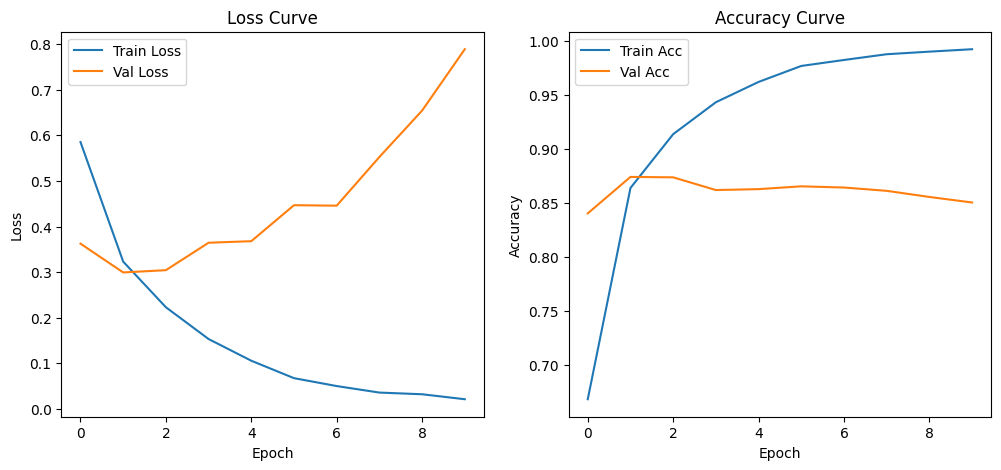

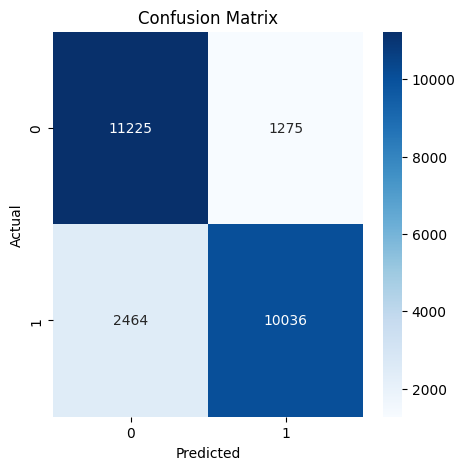

              precision    recall  f1-score   support

           0     0.8200    0.8980    0.8572     12500
           1     0.8873    0.8029    0.8430     12500

    accuracy                         0.8504     25000
   macro avg     0.8536    0.8504    0.8501     25000
weighted avg     0.8536    0.8504    0.8501     25000



In [ ]:
##### YOUR CODE HERE #####

!pip install tqdm
import tqdm

# Plots and outputs of loss, accuracy, and other diagnostics

epochs = 10
hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, cm, report = eval_model(model, test_dataloader, criterion, device)

    hist["train_loss"].append(train_loss)
    hist["train_acc"].append(train_acc)
    hist["val_loss"].append(val_loss)
    hist["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc*100:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

# Confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(report)

### Question 3d

**Your answer:**

The BOW + Logistic Regression model achieves high validation accuracy (about 88%) and shows minimal overfitting, with training and validation performance closely aligned. In contrast, the Word Embedding + CNN model overfits heavily: training accuracy is very high (about 99%) but validation accuracy drops (about 86%), indicating poor generalization. BOW performs better here due to its simplicity and the clear signal in word counts. To improve the CNN, one could adjust dropout rates, freeze or fine-tune embeddings, change kernel sizes, and tune learning rates.



### Optional

Matched 22525/30002 (75.1%) words to pretrained vectors.


 10%|█         | 1/10 [00:23<03:31, 23.50s/it]

Epoch 1/10: Train Loss=0.6933, Train Acc=49.86%, Val Loss=0.6930, Val Acc=50.33%


 20%|██        | 2/10 [00:47<03:09, 23.63s/it]

Epoch 2/10: Train Loss=0.6898, Train Acc=50.60%, Val Loss=0.6953, Val Acc=50.45%


 30%|███       | 3/10 [01:10<02:44, 23.46s/it]

Epoch 3/10: Train Loss=0.6744, Train Acc=51.77%, Val Loss=0.7081, Val Acc=50.06%


 40%|████      | 4/10 [01:33<02:20, 23.40s/it]

Epoch 4/10: Train Loss=0.6624, Train Acc=52.51%, Val Loss=0.7150, Val Acc=50.43%


 50%|█████     | 5/10 [01:57<01:57, 23.57s/it]

Epoch 5/10: Train Loss=0.6597, Train Acc=52.90%, Val Loss=0.7137, Val Acc=50.00%


 60%|██████    | 6/10 [02:21<01:34, 23.61s/it]

Epoch 6/10: Train Loss=0.6591, Train Acc=53.12%, Val Loss=0.7330, Val Acc=49.97%


 70%|███████   | 7/10 [02:44<01:10, 23.60s/it]

Epoch 7/10: Train Loss=0.6579, Train Acc=52.70%, Val Loss=0.7439, Val Acc=50.44%


 80%|████████  | 8/10 [03:08<00:47, 23.57s/it]

Epoch 8/10: Train Loss=0.6573, Train Acc=52.08%, Val Loss=0.7522, Val Acc=50.45%


 90%|█████████ | 9/10 [03:32<00:23, 23.58s/it]

Epoch 9/10: Train Loss=0.6566, Train Acc=52.92%, Val Loss=0.7465, Val Acc=50.03%


100%|██████████| 10/10 [03:55<00:00, 23.58s/it]

Epoch 10/10: Train Loss=0.6566, Train Acc=53.02%, Val Loss=0.7625, Val Acc=50.32%


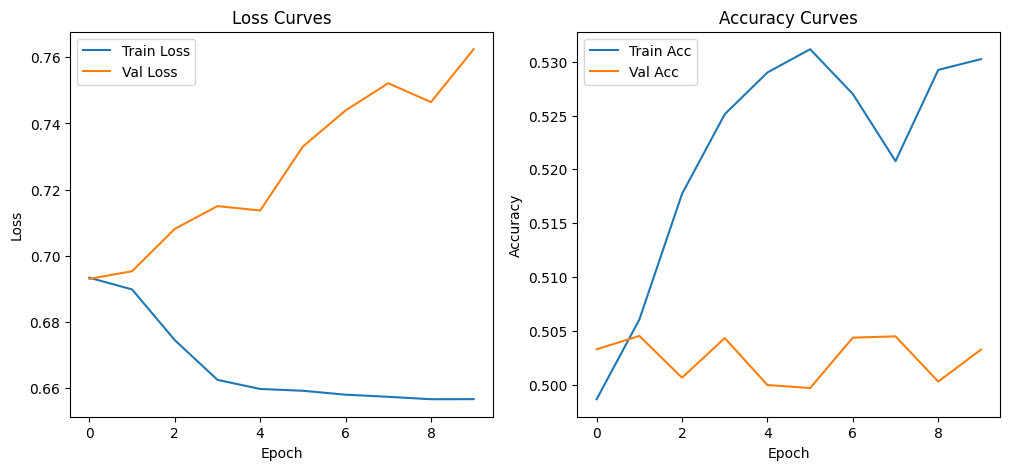

Confusion Matrix:
 [[12034   466]
 [11953   547]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.5017    0.9627    0.6596     12500
         1.0     0.5400    0.0438    0.0810     12500

    accuracy                         0.5032     25000
   macro avg     0.5208    0.5032    0.3703     25000
weighted avg     0.5208    0.5032    0.3703     25000



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM model
class LSTMTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.2):
        super().__init__()
        V, D = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=D,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)               # [B, L] -> [B, L, D]
        lstm_out, _ = self.lstm(emb)         # [B, L, hidden*directions]
        lstm_last = lstm_out[:, -1, :]       # last timestep [B, hidden*directions]
        out = self.dropout(lstm_last)
        out = self.fc(out)
        out = self.sigmoid(out)              # [B,1]
        return out

# Build embedding matrix
embedding_matrix = build_w2v_embedding_matrix(word2idx, wv_from_bin)
embedding_matrix = embedding_matrix.to(device)

# Initialize model
model = LSTMTextClassifier(embedding_matrix, hidden_dim=128, num_layers=1, bidirectional=True, dropout=0.2)
model.to(device)

# Criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop as usual
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_examples = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device).float()   # [B,1]
        optimizer.zero_grad()
        y_pred = model(X)                           # [B,1]
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        preds = (y_pred > 0.5).long()
        total_correct += (preds == y.long()).sum().item()
        total_examples += X.size(0)
    return total_loss / total_examples, total_correct / total_examples

# Eval loop as usual
def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_examples = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).float()
            y_pred = model(X)
            loss = criterion(y_pred, y)

            total_loss += loss.item() * X.size(0)
            preds = (y_pred > 0.5).long()
            total_correct += (preds == y.long()).sum().item()
            total_examples += X.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)
    return avg_loss, avg_acc, cm, report

# Training loop as usual
epochs = 10
hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in tqdm.tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, cm, report = eval_model(model, test_dataloader, criterion, device)

    hist["train_loss"].append(train_loss)
    hist["train_acc"].append(train_acc)
    hist["val_loss"].append(val_loss)
    hist["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc*100:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%")

# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

# Print confusion matrix
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

In [ ]:
for X, y in train_dataloader:
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("First sequence:", X[0][:50])
    print("Label:", y[0])
    break

X shape: torch.Size([64, 600])
y shape: torch.Size([64, 1])
First sequence: tensor([  360,    56,     8,     2,   520,  5279,  1330,  1267,     8,     2,
          288,   606,   467, 11979,     8,   338,     6,   276,   147,    23,
            5,  6548,  3574,    10,   587,     3,  2080,  2206,    11, 25463,
           24,   103,  1992,    19,     2,  3572,     7,    25,   101,  1648,
           21,     2,    50,  2567,  4002,    42,   113,    97,   934,     2])
Label: tensor([1.])


# Question 2: Deep Q learning for a classic control problem

In [ ]:
!apt install xvfb ffmpeg freeglut3-dev
!pip install imageio
!pip install pyvirtualdisplay
!pip install pyglet
!pip install gymnasium[classic_control]
!pip install moviepy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
The following additional packages will be installed:
  freeglut3 libegl-dev libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev
  libopengl-dev libxt-dev
Suggested packages:
  libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libopengl-dev libxt-dev
0 upgraded, 14 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,192 kB of archives.
After this operation, 6,439 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ub

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import namedtuple, deque
import random

## 2. Implementing DQN for the Cartpole Problem

### The Cartpole Environment

In [ ]:
# Load the cartpole environment
env = gym.make('CartPole-v1')

# Get the number of actions and the dimension of the observation space
num_actions = env.action_space.n
state_shape = env.observation_space.shape
print(f"Actions: {num_actions}, State Shape: {state_shape}")

Actions: 2, State Shape: (4,)


In [ ]:
# Define the neural network model
class QModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, num_actions):
        super(QModel, self).__init__()
        layers_list = []
        layers_list.append(nn.Linear(input_dim, layer_sizes[0]))
        layers_list.append(nn.ReLU())
        for i in range(1, len(layer_sizes) - 1):
            layers_list.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            layers_list.append(nn.ReLU())
        layers_list.append(nn.Linear(layer_sizes[-1], num_actions, bias=False))
        self.model = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.model(x)

# Function to create Q models
def create_q_models(input_dim, layer_sizes, num_actions, do_target=False):
    model = QModel(input_dim, layer_sizes, num_actions)
    if do_target:
        target = QModel(input_dim, layer_sizes, num_actions)
        target.load_state_dict(model.state_dict()) # Sync weights initially
        target.eval() # Set target to evaluation mode
        return model, target
    return model

# Architecture for our feedforward nets
layer_sizes = [32, 32, 32]

# Initialize Q models
model = create_q_models(state_shape[0], layer_sizes, num_actions)
model_target = create_q_models(state_shape[0], layer_sizes, num_actions)  # For simplicity, in this case, the target model is the same as the main model

In [ ]:
# Define ReplayMemory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# -- Parameters
# Discount factor for past rewards
gamma = 0.99

# Epsilon-greedy decay parameters
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter

# This is the number of frames it will take to go from min to max epsilon
# Controls the rate of change of epsilon.
epsilon_greedy_frames = 20_000
epsilon_interval = epsilon_max - epsilon_min

# Size of each training batch
batch_size = 32

# Make sure episodes don't last forever
max_steps_per_episode = 10000

# Train the model after 4 actions -- learning every step is slow and unstable.
update_after_actions = 4

# Other losses are sometimes used in DQNs (e.g. Huber for Atari)
loss_function = nn.MSELoss()

### Q1-3: Complete the following codes according to the pseudoalgorithm.

running reward: 20.45 at episode 47, frame count 1000, greedy prob 0.04500000000000004, time spent so far 0.01m
running reward: 20.84 at episode 94, frame count 2000, greedy prob 0.08999999999999997, time spent so far 0.01m
Making plots after 100 episodes


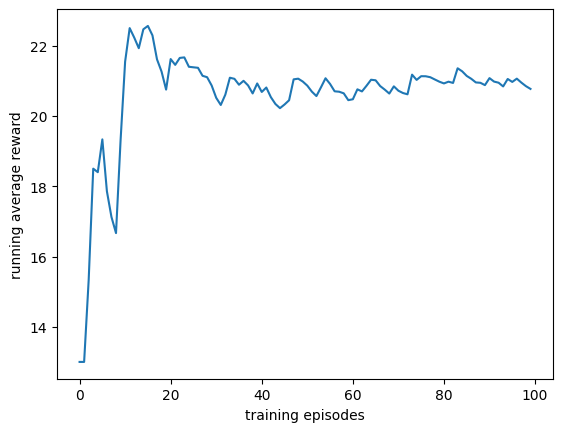

running reward: 21.18 at episode 142, frame count 3000, greedy prob 0.135, time spent so far 0.02m
running reward: 23.21 at episode 180, frame count 4000, greedy prob 0.17999999999999994, time spent so far 0.03m
Making plots after 200 episodes


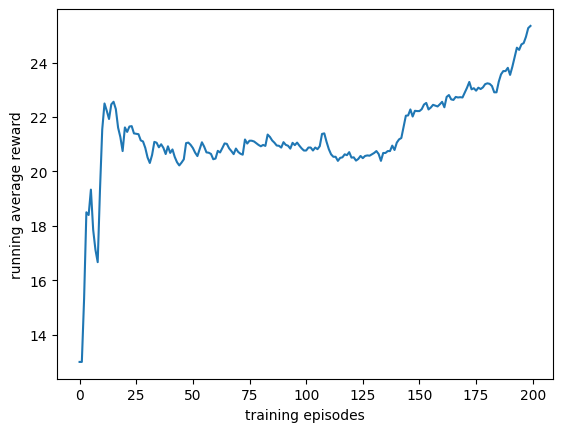

running reward: 26.82 at episode 210, frame count 5000, greedy prob 0.22499999999999998, time spent so far 0.04m
running reward: 31.57 at episode 235, frame count 6000, greedy prob 0.27, time spent so far 0.05m
running reward: 35.32 at episode 258, frame count 7000, greedy prob 0.31499999999999995, time spent so far 0.06m
running reward: 37.80 at episode 286, frame count 8000, greedy prob 0.36, time spent so far 0.07m
Making plots after 300 episodes


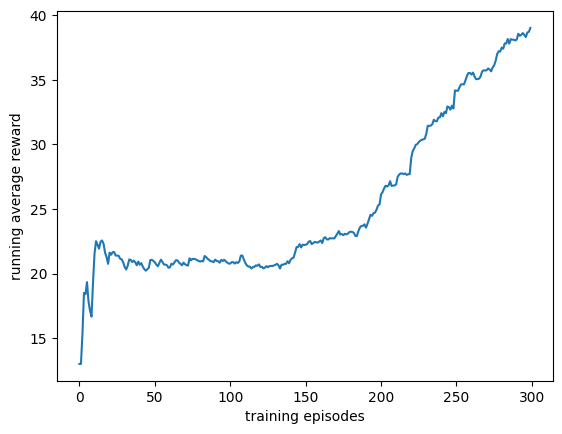

running reward: 40.21 at episode 307, frame count 9000, greedy prob 0.405, time spent so far 0.08m
running reward: 44.29 at episode 324, frame count 10000, greedy prob 0.44999999999999996, time spent so far 0.09m
running reward: 49.39 at episode 337, frame count 11000, greedy prob 0.495, time spent so far 0.09m
running reward: 54.53 at episode 342, frame count 12000, greedy prob 0.54, time spent so far 0.10m
running reward: 59.65 at episode 356, frame count 13000, greedy prob 0.585, time spent so far 0.11m
running reward: 67.64 at episode 363, frame count 14000, greedy prob 0.63, time spent so far 0.12m
running reward: 76.73 at episode 369, frame count 15000, greedy prob 0.675, time spent so far 0.12m
running reward: 82.82 at episode 378, frame count 16000, greedy prob 0.72, time spent so far 0.13m
running reward: 90.69 at episode 386, frame count 17000, greedy prob 0.765, time spent so far 0.14m
running reward: 97.65 at episode 389, frame count 18000, greedy prob 0.81, time spent so f

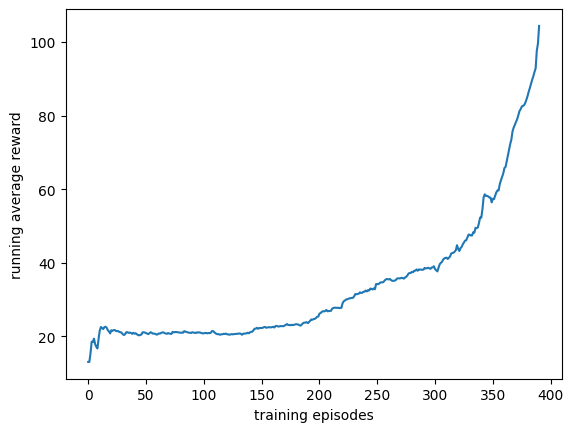

Solved at episode 391!


In [ ]:
# Set seed
random.seed(42)
rng = np.random.default_rng(42)

# Initialize optimizer
optimizer = optim.Adam(model.parameters())

# Initialize memory, but with max capacity equal to batch_size.
memory = ReplayMemory(batch_size)

log_interval = 1000
running_reward = 0
episode_count = 0
frame_count = 0
epsilon = epsilon_max
episode_reward_history = []
running_reward_history = []
# track the time spent training
tic = time.time()

# Run until solved
while True:
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Decay probability of taking random action
        # Q1: Implement epsilon decay
        # Epsilon should decay linearly from epsilon_max to epsilon_min
        # starting at epsilon_max when `frame_count==0`, and ending at
        # epsilon_min when `frame_count==epsilon_greedy_frames`.

        ### Your code here ##
        if frame_count < epsilon_greedy_frames:
          epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
          epsilon = epsilon_min

        # Use epsilon-greedy for exploration
        # Q2: implement epsilon greedy.
        # With probability epsilon, set action to a randomly chosen action
        # Else, use the best action according to model (not target_model).
        ### Your code here ##
        if random.random() < epsilon:
          action = env.action_space.sample()
        else:
          with torch.no_grad():
            q_values = model(state.unsqueeze(0))
            action = torch.argmax(q_values).item()


        state_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        # Convert to tensors before pushing to memory
        state_next = torch.tensor(state_next, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float32)
        done_tensor = torch.tensor(done, dtype=torch.float32)

        # Store the transition in memory
        memory.push(state, action, state_next, reward, done_tensor)
        state = state_next

        if frame_count % update_after_actions == 0 and len(memory) == batch_size:
            # This is the "no-replay" part: we just use the *entire* buffer
            transitions = list(memory.memory)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            # Q3: Computing the DQN loss.
            # We will break this into 3 steps.

            # Q3.a: use model to predict the Q values at the minibatch of next
            # states, `next_state_batch`.
            # Since we are not using a target network, this is slightly different
            # from the Qhat(s', a') in the pseudocode above: use the model,
            # not model_target, to predict Q.

            ### Your code here ##
            with torch.no_grad():
              next_q_values = model(next_state_batch)

            # Q3.b: Find the maximum reward at these future states
            # This corresponds to max_{a'} Qhat(s', a') in the pseudocode above
            # Take the maximum over actions of Q_hat

            ### Your code here ##
            max_next_q_values, _ = torch.max(next_q_values, dim=1)

            # Q3.c: Compute the target y in the loss
            # target = (reward at this sample) + (discount factor) * (optimal reward at future sample)
            # This corresponds to y_i in the pseudocode above.

            ### Your code here ##
            target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            optimizer.zero_grad()
            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)
            loss = loss_function(q_action, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if not frame_count % log_interval:
            toc = time.time()
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}, time spent so far {:.2f}m"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon, (toc - tic) / 60))

        if done:
            break

    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print("Making plots after", episode_count, "episodes")
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

### Q4: Train again with experience replay and the target network

In [ ]:
## -- Experience replay and target model logic
# Maximum replay length
# Note: The Deepmind Atari paper suggests 1000000 however this causes memory issues
max_memory_length = 100000

# How often to update the target network
update_target_network = 1000

# Create a new model so that we can train from scratch
# Also initialize a target model with the same architecture
model, model_target = create_q_models(state_shape[0], layer_sizes, num_actions, do_target=True)

running reward: 21.39 at episode 46, frame count 1000, greedy prob 0.04500000000000004
running reward: 20.82 at episode 95, frame count 2000, greedy prob 0.08999999999999997
100


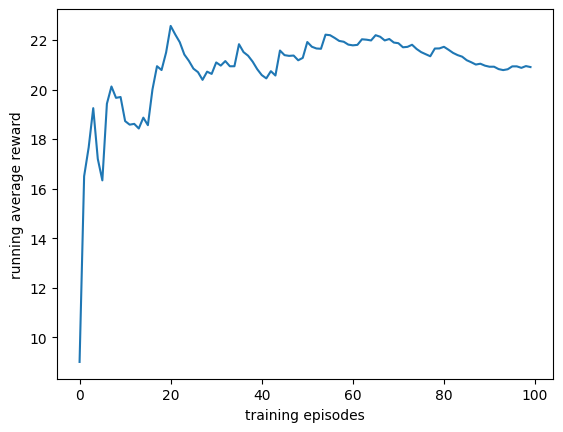

running reward: 21.35 at episode 141, frame count 3000, greedy prob 0.135
running reward: 22.19 at episode 181, frame count 4000, greedy prob 0.17999999999999994
200


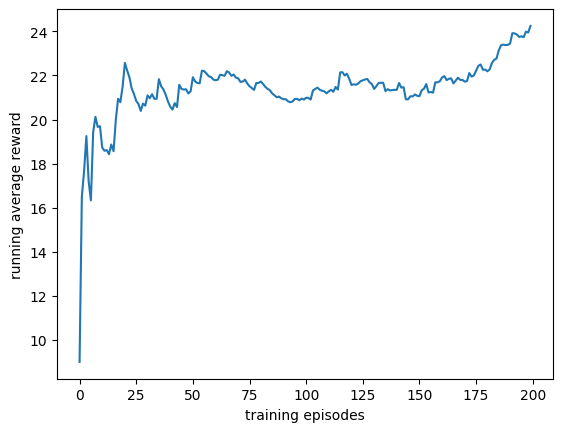

running reward: 25.59 at episode 215, frame count 5000, greedy prob 0.22499999999999998
running reward: 28.77 at episode 242, frame count 6000, greedy prob 0.27
running reward: 34.19 at episode 262, frame count 7000, greedy prob 0.31499999999999995
running reward: 39.97 at episode 281, frame count 8000, greedy prob 0.36
running reward: 46.08 at episode 296, frame count 9000, greedy prob 0.405
300


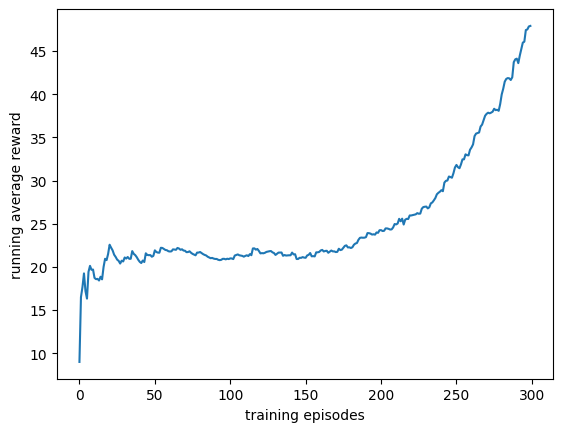

running reward: 52.61 at episode 308, frame count 10000, greedy prob 0.44999999999999996
running reward: 56.88 at episode 323, frame count 11000, greedy prob 0.495
running reward: 63.19 at episode 329, frame count 12000, greedy prob 0.54
running reward: 72.68 at episode 334, frame count 13000, greedy prob 0.585
running reward: 81.35 at episode 340, frame count 14000, greedy prob 0.63
running reward: 89.04 at episode 345, frame count 15000, greedy prob 0.675
running reward: 96.50 at episode 348, frame count 16000, greedy prob 0.72
350


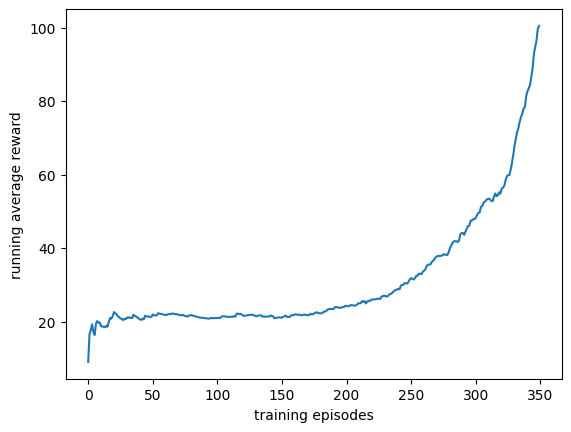

Solved at episode 350!


In [ ]:
# Set seed
random.seed(42)
rng = np.random.default_rng(42)

# -- Initialize training loop variables
optimizer = optim.Adam(model.parameters())

# Experience replay buffer
memory = ReplayMemory(max_memory_length)

# reset histories and counters
running_reward = 0
episode_count = 0
frame_count = 0
episode_reward_history = []
running_reward_history = []

# epsilon for epsilon-greedy. will be modified in the training loop.
epsilon = epsilon_max

# Run until solved
while True:
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    episode_reward = 0

    # Episode loop
    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Decay probability of taking random action
        # Q4.a: Implement epsilon decay
        # This code should be exactly the same as your code above in Q1
        ### Your code here ##
        if frame_count < epsilon_greedy_frames:
          epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
          epsilon = epsilon_min

        # Use epsilon-greedy for exploration
        # Q4.b: implement epsilon greedy.
        # This code should be exactly the same as your code above in Q2
        ### Your code here ##
        if random.random() < epsilon:
          action = env.action_space.sample()
        else:
          with torch.no_grad():
            q_values = model(state.unsqueeze(0))
            action = torch.argmax(q_values).item()

        # Apply the sampled action in our environment
        state_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        episode_reward += reward

        # Convert to tensors and store in replay buffer
        state_next = torch.tensor(state_next, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float32)
        done_tensor = torch.tensor(done, dtype=torch.float32)

        memory.push(state, action, state_next, reward, done_tensor)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(memory) > batch_size:
            # Sample a random batch from the replay buffer
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            # Computing the DQN loss.
            # We will break this into 3 steps.

            # Q4.c: Predicting Q values
            # <!> This requires some changes from above! <!>
            # Rather than using `model`, use `model_target` to predict the Q
            # values at the minibatch of next states, `state_next_sample`.
            # This is exactly Qhat(s', a') in the pseudocode above
            ### Your code here ##
            with torch.no_grad():
              next_q_values = model_target(next_state_batch)

            # Q4.d: Find the maximum reward at these future states
            # This should be the same as your code above.
            ### Your code here ##
            max_next_q_values, _ = torch.max(next_q_values, dim=1)

            # Q4.e: Compute the target y in the loss
            # This should be the same as your code above.
            ### Your code here ##
            target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            optimizer.zero_grad()
            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)

            # Calculate loss between new Q-value and old Q-value
            loss = loss_function(q_action, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if frame_count % update_target_network == 0:
            # update the target network with new weights
            model_target.load_state_dict(model.state_dict())

            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}, greedy prob {}"
            print(template.format(running_reward, episode_count, frame_count, 1 - epsilon))

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 100 or running_reward > 100:
        print(episode_count)
        plt.figure()
        plt.plot(running_reward_history)
        plt.ylabel("running average reward")
        plt.xlabel("training episodes")
        plt.show()
        plt.close("all")

    # Condition to consider the task solved
    if running_reward > 100:
        print("Solved at episode {}!".format(episode_count))
        break

### Q5. Why does experience replay help?

**YOUR ANSWER HERE:**

Experience replay helps because it breaks the correlation between consecutive transitions in reinforcement learning. By storing past experiences and sampling them randomly, the training data becomes more like i.i.d. samples, which is a key assumption for supervised learning algorithms. This stabilizes training and prevents the network from overfitting to recent experiences.


### Q6. Why does (freezing ) the target network help?

**YOUR ANSWER HERE:**

Freezing the target network helps stabilize training in Q-learning by providing a fixed reference for the Q-value updates. Since the loss function compares the predicted Q-values with target Q-values, using a frozen network prevents the targets from changing every step, reducing harmful correlations. This allows the main network to learn more reliably without relying on a constantly moving target.


### Visualizing the trained model!

In [ ]:
# --- Animate the Trained Agent ---

from pyvirtualdisplay import Display
from gymnasium.wrappers import RecordVideo


# Start virtual display
display = Display(visible=0, size=(400, 300))
display.start()

# Create a new environment, this time with video recording
# We'll use the fully trained `model` (with ER and TN)
video_env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "/content/video", episode_trigger=lambda x: True )


# Run 3 episodes
for ep in range(3):
    state, info = video_env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    total_reward = 0
    print("Recording video...")

    for _ in range(500): # Run for 500 steps
        # Use a purely greedy policy (no epsilon)
        with torch.no_grad():
            action = model(state).argmax().item()

        state, reward, terminated, truncated, _ = video_env.step(action)
        state = torch.tensor(state, dtype=torch.float32)
        total_reward += reward

        if terminated or truncated:
            break

    print(f"Video finished. Total reward: {total_reward}")

    video_env.close()

Recording video...
Video finished. Total reward: 210.0


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Recording video...
Video finished. Total reward: 182.0
Recording video...
Video finished. Total reward: 202.0


In [ ]:
# --- To display the video in Colab ---
from IPython.display import HTML
from base64 import b64encode

video_path = "/content/video/rl-video-episode-0.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

In [ ]:
video_path = "/content/video/rl-video-episode-1.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

In [ ]:
video_path = "/content/video/rl-video-episode-2.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

### Q7: Changing the reward and revisualizing

Episode 50, Running Reward: -10.000, Epsilon: 0.751


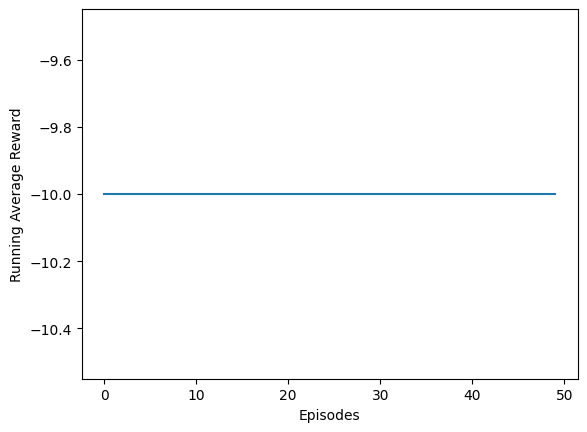

Episode 100, Running Reward: -10.000, Epsilon: 0.314


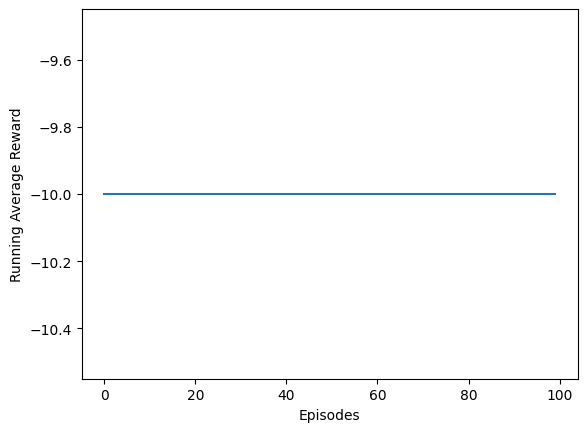

Episode 150, Running Reward: -7.000, Epsilon: 0.100


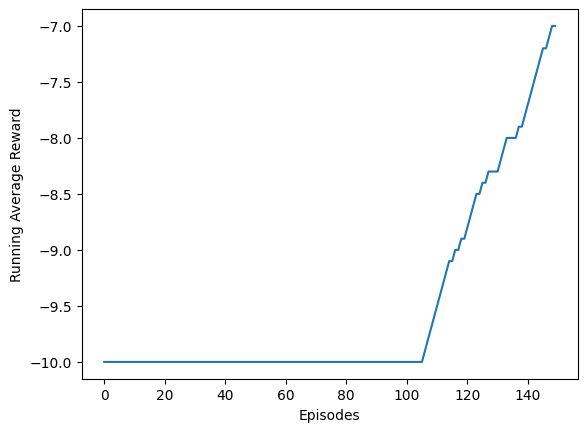

Episode 200, Running Reward: -5.700, Epsilon: 0.100


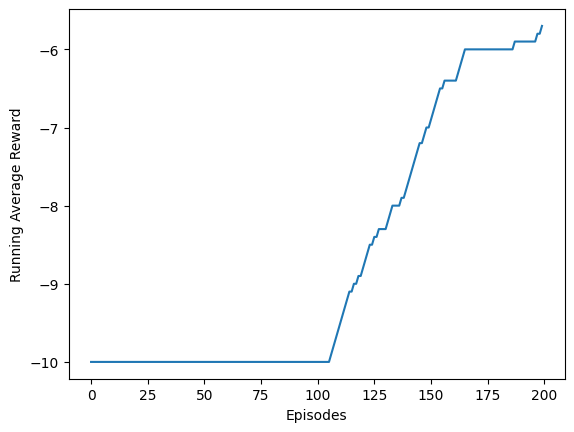

Episode 250, Running Reward: -7.900, Epsilon: 0.100


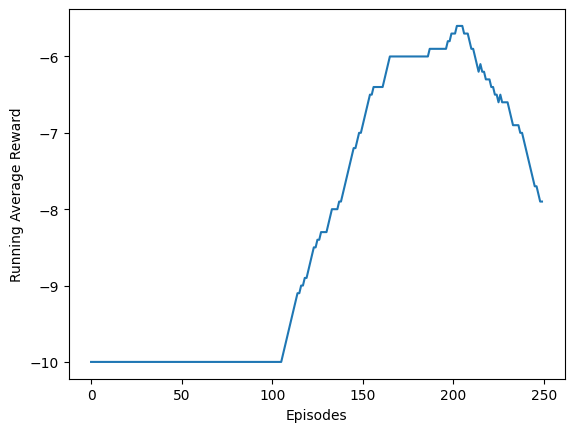

Episode 300, Running Reward: -6.500, Epsilon: 0.100


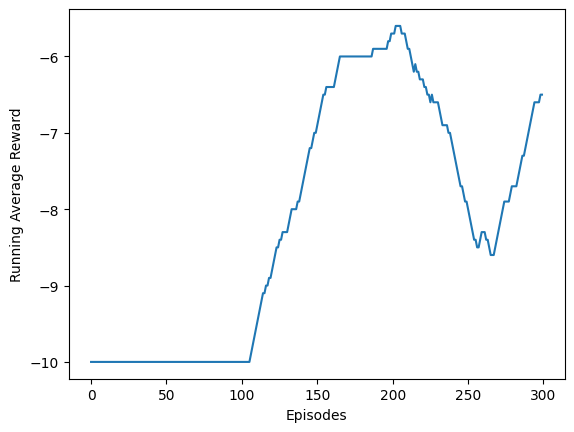

Episode 350, Running Reward: -2.600, Epsilon: 0.100


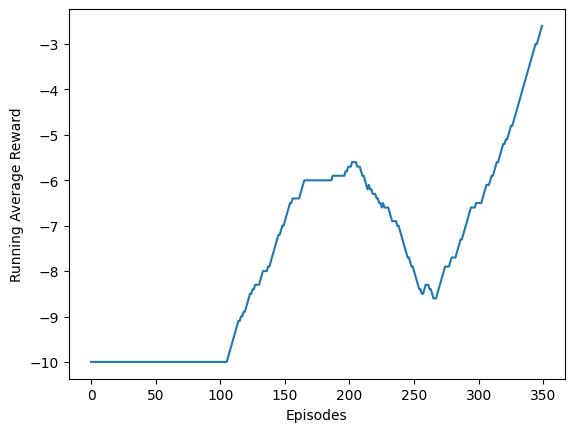

Episode 400, Running Reward: -1.200, Epsilon: 0.100


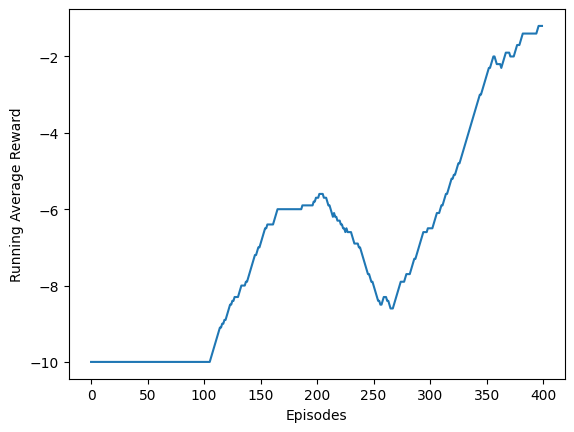

Episode 450, Running Reward: -0.900, Epsilon: 0.100


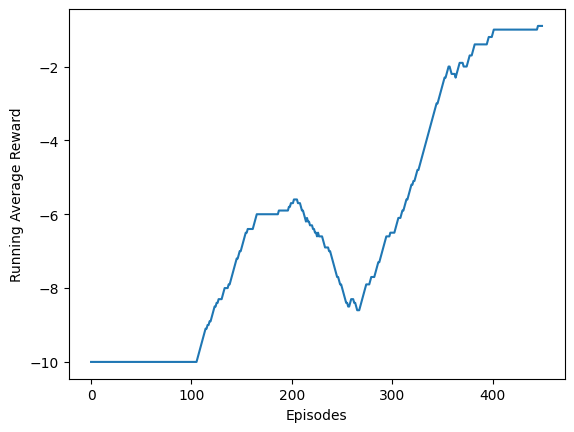

Episode 461, Running Reward: -0.400, Epsilon: 0.100


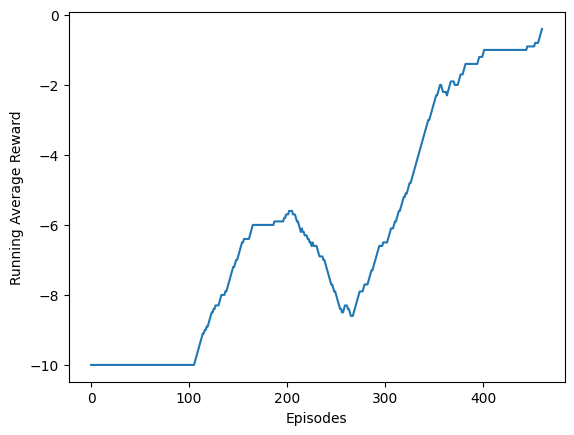

Solved at episode 461!


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Create CartPole environment with Sutton-Barto rewards
env = gym.make("CartPole-v1", sutton_barto_reward=True)

# Hyperparameters
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n
layer_sizes = [64, 64, 64]      # Slightly bigger network
gamma = 0.99
epsilon_max = 1.0
epsilon_min = 0.1
epsilon_greedy_frames = 5000     # Faster decay
epsilon_interval = epsilon_max - epsilon_min
batch_size = 32
update_after_actions = 4
update_target_network = 1000
max_steps_per_episode = 500
max_memory_length = 10000
learning_rate = 1e-4             # Lower LR for small rewards

# Replay memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# Q-network
class QModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, num_actions):
        super().__init__()
        layers_list = [nn.Linear(input_dim, layer_sizes[0]), nn.ReLU()]
        for i in range(1, len(layer_sizes)):
            layers_list.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers_list.append(nn.ReLU())
        layers_list.append(nn.Linear(layer_sizes[-1], num_actions, bias=False))
        self.model = nn.Sequential(*layers_list)
    def forward(self, x):
        return self.model(x)

# Initialize model and target
model = QModel(state_dim, layer_sizes, num_actions)
model_target = QModel(state_dim, layer_sizes, num_actions)
model_target.load_state_dict(model.state_dict())
model_target.eval()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.SmoothL1Loss()   # Huber loss

memory = ReplayMemory(max_memory_length)

# Training variables
running_reward = 0
episode_count = 0
frame_count = 0
episode_reward_history = []
running_reward_history = []
epsilon = epsilon_max

tic = time.time()

while True:
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    episode_reward = 0

    for t in range(1, max_steps_per_episode + 1):
        frame_count += 1

        # Epsilon decay
        if frame_count < epsilon_greedy_frames:
            epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
            epsilon = epsilon_min

        # Epsilon-greedy action
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = model(state.unsqueeze(0))
                action = torch.argmax(q_values).item()

        state_next, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Scale reward for Sutton-Barto
        reward_scaled = reward * 10.0
        episode_reward += reward_scaled

        # Convert to tensors and store in memory
        state_next = torch.tensor(state_next, dtype=torch.float32)
        memory.push(state, torch.tensor(action, dtype=torch.long),
                    state_next, torch.tensor(reward_scaled, dtype=torch.float32),
                    torch.tensor(done, dtype=torch.float32))
        state = state_next

        # Update network
        if frame_count % update_after_actions == 0 and len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            with torch.no_grad():
                next_q_values = model_target(next_state_batch)
                max_next_q_values, _ = torch.max(next_q_values, dim=1)
                target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)
            loss = loss_function(q_action, target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update target network
        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        if done:
            break

    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if not episode_count % 50 or running_reward > -0.5:
        print(f"Episode {episode_count}, Running Reward: {running_reward:.3f}, Epsilon: {epsilon:.3f}")
        plt.figure()
        plt.plot(running_reward_history)
        plt.xlabel("Episodes")
        plt.ylabel("Running Average Reward")
        plt.show()
        plt.close("all")

    if running_reward > -0.5:
        print(f"Solved at episode {episode_count}!")
        break


### Bonus! Try solving a harder task: `LunarLander-v3`

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399016 sha256=c534482b7df2f2fec45d075f69e9c3665d48d4f3060a8c9d88f9aded6206cca8
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py
Actions: 4, State shape: 8
Episode 10, Running Reward: -228.31, Epsilon: 0.980
Episode 20, Running Reward: -191.04, Epsilon: 0.962
Episode 30, Running Reward: -208.60, Epsilon: 0.943
Episode 40, Running Reward: -191.94, Epsilon: 0.925
Episode 50, Running Reward: -190.75, Epsilon: 0.906


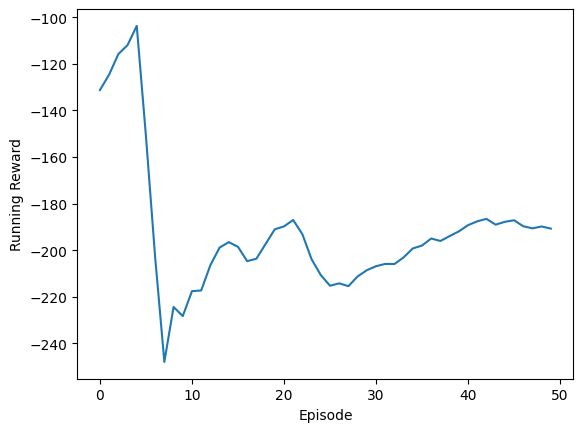

Episode 60, Running Reward: -176.70, Epsilon: 0.889
Episode 70, Running Reward: -169.75, Epsilon: 0.871
Episode 80, Running Reward: -169.43, Epsilon: 0.852
Episode 90, Running Reward: -165.36, Epsilon: 0.835
Episode 100, Running Reward: -160.75, Epsilon: 0.812


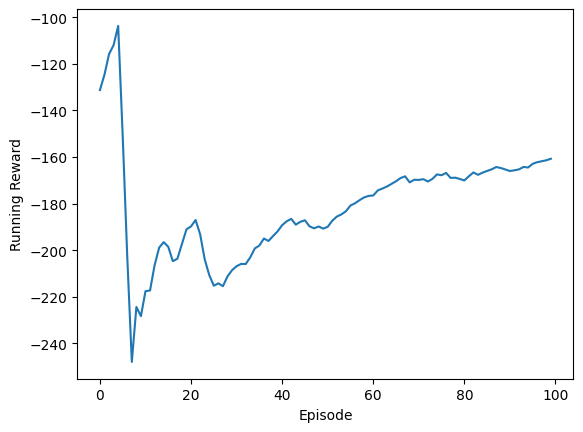

Episode 110, Running Reward: -149.86, Epsilon: 0.792
Episode 120, Running Reward: -144.66, Epsilon: 0.772
Episode 130, Running Reward: -129.99, Epsilon: 0.754
Episode 140, Running Reward: -126.83, Epsilon: 0.733
Episode 150, Running Reward: -118.27, Epsilon: 0.713


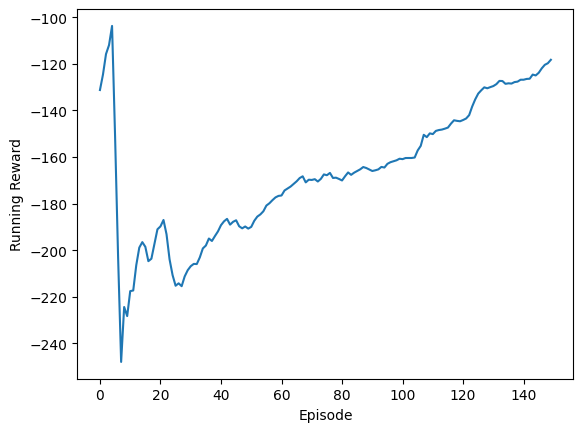

Episode 160, Running Reward: -116.68, Epsilon: 0.693
Episode 170, Running Reward: -112.04, Epsilon: 0.667
Episode 180, Running Reward: -104.19, Epsilon: 0.643
Episode 190, Running Reward: -97.14, Epsilon: 0.620
Episode 200, Running Reward: -90.64, Epsilon: 0.591


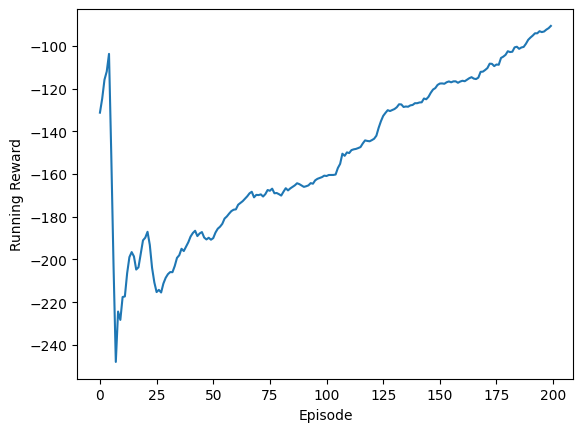

Episode 210, Running Reward: -84.44, Epsilon: 0.566
Episode 220, Running Reward: -81.53, Epsilon: 0.539
Episode 230, Running Reward: -77.92, Epsilon: 0.477
Episode 240, Running Reward: -73.82, Epsilon: 0.428
Episode 250, Running Reward: -69.34, Epsilon: 0.388


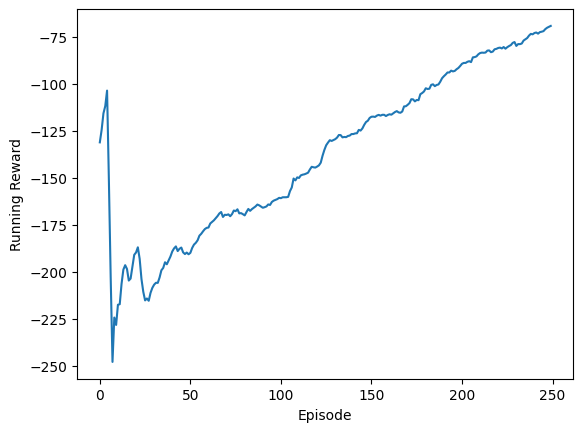

Episode 260, Running Reward: -74.35, Epsilon: 0.301
Episode 270, Running Reward: -73.94, Epsilon: 0.204
Episode 280, Running Reward: -72.41, Epsilon: 0.050
Episode 290, Running Reward: -70.41, Epsilon: 0.050
Episode 300, Running Reward: -70.69, Epsilon: 0.050


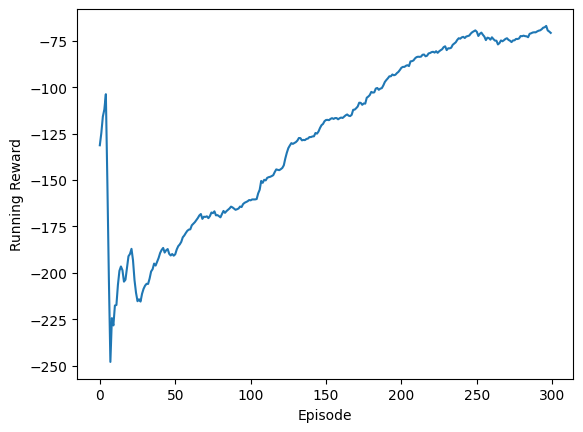

Episode 310, Running Reward: -70.51, Epsilon: 0.050
Episode 320, Running Reward: -68.84, Epsilon: 0.050
Episode 330, Running Reward: -67.73, Epsilon: 0.050
Episode 340, Running Reward: -65.50, Epsilon: 0.050
Episode 350, Running Reward: -64.58, Epsilon: 0.050


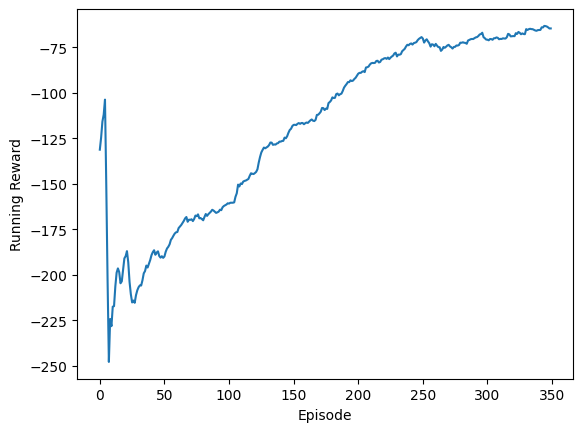

Episode 360, Running Reward: -54.87, Epsilon: 0.050
Episode 370, Running Reward: -51.77, Epsilon: 0.050
Episode 380, Running Reward: -49.34, Epsilon: 0.050
Episode 390, Running Reward: -51.83, Epsilon: 0.050
Episode 400, Running Reward: -47.87, Epsilon: 0.050


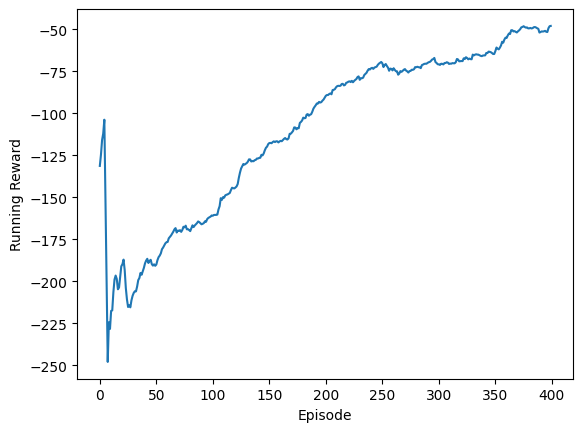

Episode 410, Running Reward: -45.58, Epsilon: 0.050
Episode 420, Running Reward: -39.94, Epsilon: 0.050
Episode 430, Running Reward: -30.29, Epsilon: 0.050
Episode 440, Running Reward: -15.48, Epsilon: 0.050
Episode 450, Running Reward: 5.14, Epsilon: 0.050


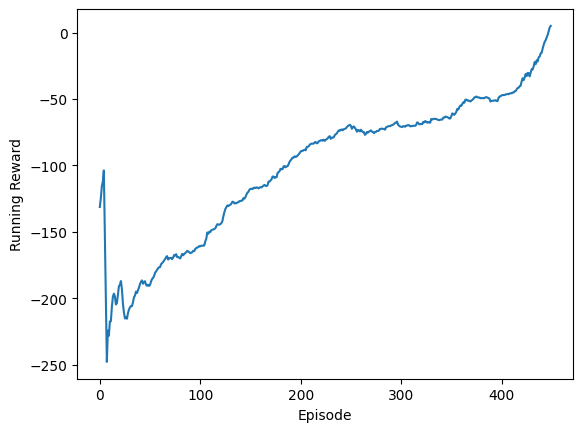

Episode 460, Running Reward: 18.38, Epsilon: 0.050
Episode 470, Running Reward: 46.29, Epsilon: 0.050
Episode 480, Running Reward: 74.62, Epsilon: 0.050
Episode 490, Running Reward: 103.40, Epsilon: 0.050
Episode 500, Running Reward: 130.62, Epsilon: 0.050


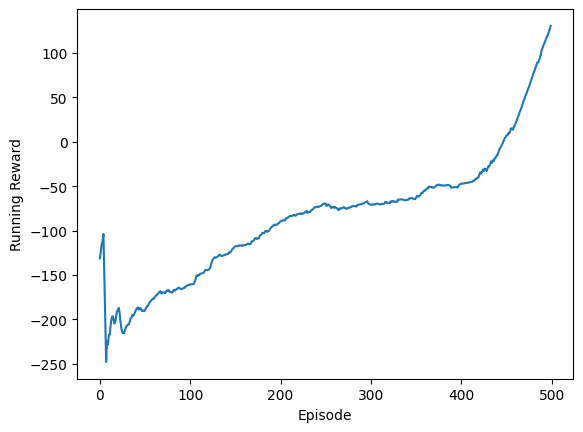

Episode 510, Running Reward: 156.00, Epsilon: 0.050
Episode 520, Running Reward: 178.95, Epsilon: 0.050
Episode 530, Running Reward: 199.26, Epsilon: 0.050
Solved LunarLander at episode 532!


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import time
!pip install swig
!pip install "gymnasium[box2d]"

# Environment
env = gym.make("LunarLander-v3", continuous=False)

num_actions = env.action_space.n
state_shape = env.observation_space.shape[0]

print(f"Actions: {num_actions}, State shape: {state_shape}")

# Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Q Network
class QModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, num_actions):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, layer_sizes[0]))
        layers.append(nn.ReLU())
        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], num_actions))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def create_q_models(input_dim, layer_sizes, num_actions, do_target=False):
    model = QModel(input_dim, layer_sizes, num_actions)
    if do_target:
        target = QModel(input_dim, layer_sizes, num_actions)
        target.load_state_dict(model.state_dict())
        target.eval()
        return model, target
    return model

# Hyperparameters
layer_sizes = [128, 128]
batch_size = 64
gamma = 0.99
epsilon_max = 1.0
epsilon_min = 0.05
epsilon_greedy_frames = 50_000
epsilon_interval = epsilon_max - epsilon_min
max_steps_per_episode = 1000
update_after_actions = 4
update_target_network = 1000
max_memory_length = 50_000
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialize
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

model, model_target = create_q_models(state_shape, layer_sizes, num_actions, do_target=True)
model.to(device)
model_target.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
memory = ReplayMemory(max_memory_length)


# Training loop
running_reward_history = []
episode_reward_history = []
frame_count = 0
episode_count = 0
epsilon = epsilon_max

tic = time.time()

while True:
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    episode_reward = 0

    for t in range(max_steps_per_episode):
        frame_count += 1

        # Epsilon decay
        if frame_count < epsilon_greedy_frames:
            epsilon = epsilon_max - (epsilon_interval * frame_count / epsilon_greedy_frames)
        else:
            epsilon = epsilon_min

        # Epsilon-greedy action
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = model(state.unsqueeze(0))
                action = torch.argmax(q_values).item()

        # Step environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device)
        reward_tensor = torch.tensor(reward, dtype=torch.float32, device=device)
        action_tensor = torch.tensor(action, dtype=torch.long, device=device)
        done_tensor = torch.tensor(done, dtype=torch.float32, device=device)

        memory.push(state, action_tensor, next_state_tensor, reward_tensor, done_tensor)
        state = next_state_tensor

        # Update network
        if frame_count % update_after_actions == 0 and len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).unsqueeze(1)
            reward_batch = torch.stack(batch.reward)
            next_state_batch = torch.stack(batch.next_state)
            done_batch = torch.stack(batch.done)

            # Compute target using target network
            with torch.no_grad():
                next_q_values = model_target(next_state_batch)
                max_next_q_values, _ = torch.max(next_q_values, dim=1)
                target = reward_batch + gamma * max_next_q_values * (1 - done_batch)

            optimizer.zero_grad()
            q_values = model(state_batch)
            q_action = q_values.gather(1, action_batch)
            loss = loss_function(q_action, target.unsqueeze(1))
            loss.backward()
            optimizer.step()

        # Update target network periodically
        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        if done:
            break

    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1

    if episode_count % 10 == 0:
        print(f"Episode {episode_count}, Running Reward: {running_reward:.2f}, Epsilon: {epsilon:.3f}")

    # Plot progress every 50 episodes
    if episode_count % 50 == 0:
        plt.figure()
        plt.plot(running_reward_history)
        plt.xlabel("Episode")
        plt.ylabel("Running Reward")
        plt.show()
        plt.close("all")

    # Solving condition
    if running_reward >= 200:
        print(f"Solved LunarLander at episode {episode_count}!")
        break